In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
from google.colab import files
import pandas as pd
import io

# Upload file from local machine
uploaded = files.upload()

# Access the file by name from the uploaded dictionary
df = pd.read_csv(io.StringIO(uploaded['hate_speech.csv'].decode('utf-8')))
df.head()

Saving hate_speech.csv to hate_speech.csv


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
data = df[(df['class'] == 0) |
                 (df['class'] == 2) |
                 ((df['class'] == 1) & (df['offensive_language_count'] >= 4))]
data #24783 rows × 6 columns

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """
63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://..."
66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo..."
...,...,...,...,...,...,...
24776,3,3,0,0,0,you're all niggers
24777,3,2,1,0,0,you're such a retard i hope you get type 2 dia...
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24781,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
count_hate = data[data['class'] == 0].shape[0]
count_not_hate = data[data['class'] == 2].shape[0]
count_offensive = data[data['class'] == 1].shape[0]
hate_perc = count_hate/(count_not_hate+count_offensive+count_hate)
print('Hate: '+str(count_hate))
print('Not-hate: '+str(count_not_hate))
print('Offensive: '+str(count_offensive))
print('hate percentage: '+ str(hate_perc))

Hate: 1430
Not-hate: 4163
Offensive: 1610
hate percentage: 0.19852839094821603


## Data Understanding

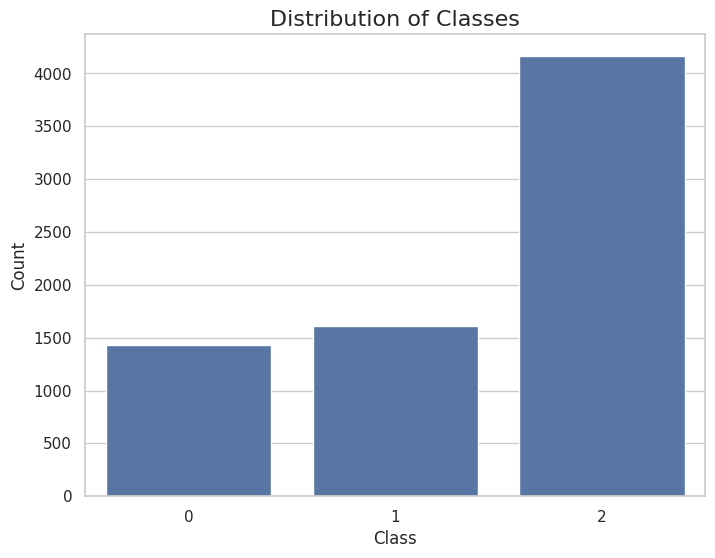

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot class distribution
plt.figure(figsize=(8,6))
sns.countplot(x='class', data=data)
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

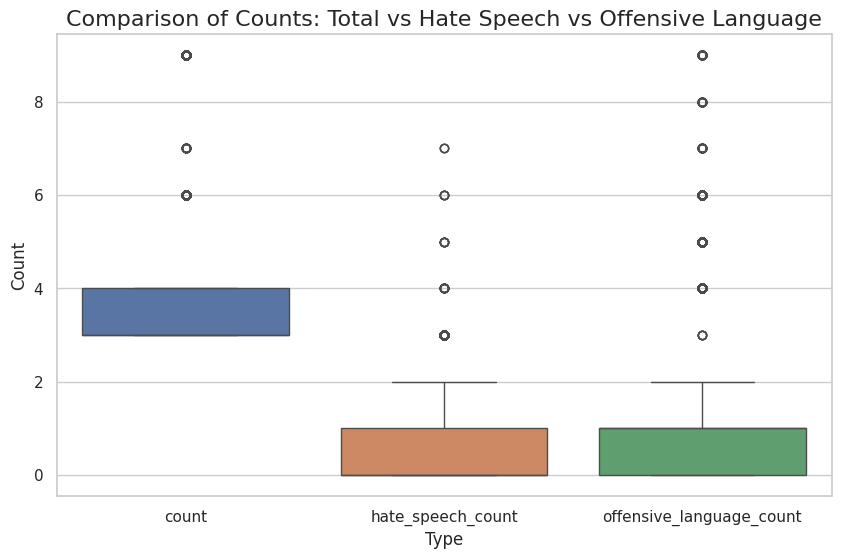

In [7]:
# Plot boxplot for count, hate_speech_count, and offensive_language_count
plt.figure(figsize=(10,6))
sns.boxplot(data=data[['count', 'hate_speech_count', 'offensive_language_count']])
plt.title('Comparison of Counts: Total vs Hate Speech vs Offensive Language', fontsize=16)
plt.xlabel('Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

<ipython-input-8-cb75b2c12493>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['length'] = data['tweet'].apply(len)


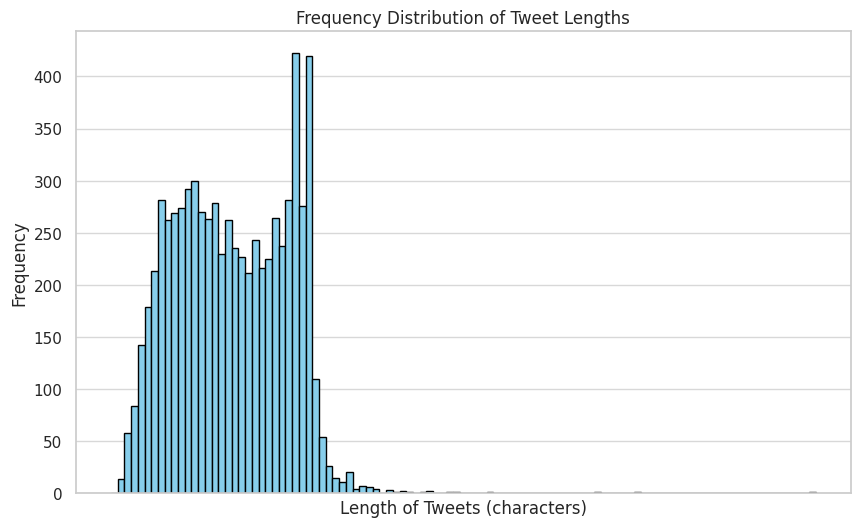

In [8]:
# Plotting the frequency distribution of tweet lengths
data['length'] = data['tweet'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(data['length'], bins=range(0, data['length'].max() + 5, 5), color='skyblue', edgecolor='black')
plt.title('Frequency Distribution of Tweet Lengths')
plt.xlabel('Length of Tweets (characters)')
plt.ylabel('Frequency')
#plt.xticks(range(0, data['length'].max() + 5, 5))
plt.xticks([])  # This line removes x-axis labels
plt.grid(axis='y', alpha=0.75)
plt.show()

## Data Quality Checks

In [9]:
# 1. Missing Values Check
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)
print('\n')
# 2. Duplicate Records Check
duplicates = data.duplicated().sum()
print("Duplicate Records:", duplicates)
print('\n')
# 3. Data Type Validation
print("Data Types:\n", data.dtypes)
print('\n')
# 4. Label Distribution Check
label_distribution = data['class'].value_counts()
print("Label Distribution:\n", label_distribution)

Missing Values:
 count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
length                      0
dtype: int64


Duplicate Records: 0


Data Types:
 count                        int64
hate_speech_count            int64
offensive_language_count     int64
neither_count                int64
class                        int64
tweet                       object
length                       int64
dtype: object


Label Distribution:
 class
2    4163
1    1610
0    1430
Name: count, dtype: int64


In [10]:
# 5. Text Length Analysis
data['tweet_length'] = data['tweet'].str.len()
print("Tweet Length Statistics:\n", data['tweet_length'].describe())

Tweet Length Statistics:
 count    7203.000000
mean       89.697487
std        41.642976
min         5.000000
25%        55.000000
50%        88.000000
75%       127.000000
max       522.000000
Name: tweet_length, dtype: float64


<ipython-input-10-cec98f252cd4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_length'] = data['tweet'].str.len()


In [11]:
data['tweet_length'] = data['tweet'].str.len()

# Print tweet length statistics
print("Tweet Length Statistics:\n", data['tweet_length'].describe())

# Calculate mean and standard deviation for tweet length
mean_length = data['tweet_length'].mean()
std_length = data['tweet_length'].std()

# Determine outlier threshold (3 standard deviations above the mean)
outlier_threshold = mean_length + 3 * std_length

# Identify outliers
length_outliers = data[data['tweet_length'] > outlier_threshold]

# Print outliers in tweet length
print("Outliers in tweet length:\n", length_outliers[['tweet', 'tweet_length']])

Tweet Length Statistics:
 count    7203.000000
mean       89.697487
std        41.642976
min         5.000000
25%        55.000000
50%        88.000000
75%       127.000000
max       522.000000
Name: tweet_length, dtype: float64
Outliers in tweet length:
                                                    tweet  tweet_length
998    &#128514;&#128514;&#128514;&#128514;&#128514; ...           239
1657   &#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...           235
1825   &#8220;@kitty_hello14: @Im_Yung_Jay &#127850;&...           254
13042  My grandma threw out all of my raps. Ones I ma...           234
13578  Okay so I know I'm like ten years late but I f...           218
14476  RT @Brianhopecomedy: &#8220;Daddy, Batman&#821...           224
15594  RT @Iaughatmypain: My anaconda don't &#128581;...           257
16539  RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1...           522
17529  RT @TM__7: &#128514;&#128514;&#128514;&#128514...           216
17710  RT @TheRealCoolie: How many

<ipython-input-11-1266c40e090b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_length'] = data['tweet'].str.len()


In [12]:
length_outliers.count()

,0
count,12
hate_speech_count,12
offensive_language_count,12
neither_count,12
class,12
tweet,12
length,12
tweet_length,12


In [13]:
def check_empty_or_short_tweets(df):
    return df[df['tweet'].str.len() < 3]

# 2. Check for Repetitive Text (Spam)
def check_repetitive_text(df, threshold=0.5):
    def repetitive_ratio(text):
        words = text.split()
        word_counts = Counter(words)
        most_common_word, count = word_counts.most_common(1)[0]
        return count / max(1, len(words))  # Ratio of most common word to total words
    return df[df['tweet'].apply(repetitive_ratio) > threshold]

# Apply the Checks on your dataset `data`
empty_tweets = check_empty_or_short_tweets(data)
print("Empty or Nearly Empty Tweets:\n", empty_tweets)

repetitive_tweets = check_repetitive_text(data)
repetitive_tweets.count()

Empty or Nearly Empty Tweets:
 Empty DataFrame
Columns: [count, hate_speech_count, offensive_language_count, neither_count, class, tweet, length, tweet_length]
Index: []


,0
count,7
hate_speech_count,7
offensive_language_count,7
neither_count,7
class,7
tweet,7
length,7
tweet_length,7


In [14]:
length_outliers['tweet']

,tweet
998,&#128514;&#128514;&#128514;&#128514;&#128514; ...
1657,&#8220;@__Black_Jesus: &#8220;@lil_aerii: Happ...
1825,&#8220;@kitty_hello14: @Im_Yung_Jay &#127850;&...
13042,My grandma threw out all of my raps. Ones I ma...
13578,Okay so I know I'm like ten years late but I f...
14476,"RT @Brianhopecomedy: &#8220;Daddy, Batman&#821..."
15594,RT @Iaughatmypain: My anaconda don't &#128581;...
16539,RT @Mr_MshkL: &#1589;&#1608;&#1585;&#1577; &#1...
17529,RT @TM__7: &#128514;&#128514;&#128514;&#128514...
17710,RT @TheRealCoolie: How many hoes do I have ?\n...


## Data pre-processing and cleaning

In [15]:
data

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,length,tweet_length
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,140
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,137
40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """,47,47
63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",87,87
66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",66,66
...,...,...,...,...,...,...,...,...
24776,3,3,0,0,0,you're all niggers,18,18
24777,3,2,1,0,0,you're such a retard i hope you get type 2 dia...,106,106
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",70,70
24781,6,0,6,0,1,youu got wild bitches tellin you lies,37,37


In [16]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase the text
    text = text.lower()
    return text

def tokenize_and_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Step 4: Remove Stop Words
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

# Complete Preprocessing Function
def preprocess_tweets(df):
    # Apply cleaning, tokenization, lemmatization, and stop word removal
    df['cleaned_tweet'] = df['tweet'].apply(clean_text)
    df['tokenized_tweet'] = df['cleaned_tweet'].apply(tokenize_and_lemmatize)
    df['final_tweet'] = df['tokenized_tweet'].apply(remove_stopwords)

    return df

In [17]:
if __name__ == "__main__":
    # Preprocess the DataFrame
    preprocessed_df = preprocess_tweets(data)
    #print(preprocessed_df[['tweet', 'final_tweet']].head())

<ipython-input-16-be924991f48d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_tweet'] = df['tweet'].apply(clean_text)
<ipython-input-16-be924991f48d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_tweet'] = df['cleaned_tweet'].apply(tokenize_and_lemmatize)
<ipython-input-16-be924991f48d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [18]:
preprocessed_df[['tweet','cleaned_tweet', 'tokenized_tweet','final_tweet']]

,tweet,cleaned_tweet,tokenized_tweet,final_tweet
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cl...,"[rt, a, a, woman, you, shouldnt, complain, abo...","[rt, woman, shouldnt, complain, cleaning, hous..."
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true ...,"[rt, the, shit, you, hear, about, me, might, b...","[rt, shit, hear, might, true, might, faker, bi..."
40,""" momma said no pussy cats inside my doghouse """,momma said no pussy cats inside my doghouse,"[momma, said, no, pussy, cat, inside, my, dogh...","[momma, said, pussy, cat, inside, doghouse]"
63,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",simplyaddictedtoguys woof woof hot scally lad,"[simplyaddictedtoguys, woof, woof, hot, scally...","[simplyaddictedtoguys, woof, woof, hot, scally..."
66,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",woof woof and hot soles,"[woof, woof, and, hot, sol]","[woof, woof, hot, sol]"
...,...,...,...,...
24776,you're all niggers,youre all niggers,"[youre, all, nigger]","[youre, nigger]"
24777,you're such a retard i hope you get type 2 dia...,youre such a retard i hope you get type diabe...,"[youre, such, a, retard, i, hope, you, get, ty...","[youre, retard, hope, get, type, diabetes, die..."
24779,"you've gone and broke the wrong heart baby, an...",youve gone and broke the wrong heart baby and ...,"[youve, gone, and, broke, the, wrong, heart, b...","[youve, gone, broke, wrong, heart, baby, drove..."
24781,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies,"[youu, got, wild, bitch, tellin, you, lie]","[youu, got, wild, bitch, tellin, lie]"


In [19]:
preprocessed_df

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,length,tweet_length,cleaned_tweet,tokenized_tweet,final_tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,140,140,rt as a woman you shouldnt complain about cl...,"[rt, a, a, woman, you, shouldnt, complain, abo...","[rt, woman, shouldnt, complain, cleaning, hous..."
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,137,137,rt the shit you hear about me might be true ...,"[rt, the, shit, you, hear, about, me, might, b...","[rt, shit, hear, might, true, might, faker, bi..."
40,3,0,1,2,2,""" momma said no pussy cats inside my doghouse """,47,47,momma said no pussy cats inside my doghouse,"[momma, said, no, pussy, cat, inside, my, dogh...","[momma, said, pussy, cat, inside, doghouse]"
63,3,0,0,3,2,"""@Addicted2Guys: -SimplyAddictedToGuys http://...",87,87,simplyaddictedtoguys woof woof hot scally lad,"[simplyaddictedtoguys, woof, woof, hot, scally...","[simplyaddictedtoguys, woof, woof, hot, scally..."
66,3,0,1,2,2,"""@AllAboutManFeet: http://t.co/3gzUpfuMev"" woo...",66,66,woof woof and hot soles,"[woof, woof, and, hot, sol]","[woof, woof, hot, sol]"
...,...,...,...,...,...,...,...,...,...,...,...
24776,3,3,0,0,0,you're all niggers,18,18,youre all niggers,"[youre, all, nigger]","[youre, nigger]"
24777,3,2,1,0,0,you're such a retard i hope you get type 2 dia...,106,106,youre such a retard i hope you get type diabe...,"[youre, such, a, retard, i, hope, you, get, ty...","[youre, retard, hope, get, type, diabetes, die..."
24779,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",70,70,youve gone and broke the wrong heart baby and ...,"[youve, gone, and, broke, the, wrong, heart, b...","[youve, gone, broke, wrong, heart, baby, drove..."
24781,6,0,6,0,1,youu got wild bitches tellin you lies,37,37,youu got wild bitches tellin you lies,"[youu, got, wild, bitch, tellin, you, lie]","[youu, got, wild, bitch, tellin, lie]"


## Session 3 & 4

## 1 split the data: for 'final_tweet' column

In [20]:
from sklearn.model_selection import train_test_split

class_counts = data['class'].value_counts(normalize=True)
print("Class Distribution:\n", class_counts)

# Train-Test Split with stratification 1 :
X_trainF, X_testF, y_trainF, y_testF = train_test_split(
    data['final_tweet'], data['class'], test_size=0.25, stratify=data['class'], random_state=42)

Class Distribution:
 class
2    0.577954
1    0.223518
0    0.198528
Name: proportion, dtype: float64


In [21]:
original_dist = data['class'].value_counts(normalize=True) * 100
train_dist = y_trainF.value_counts(normalize=True) * 100
test_dist = y_testF.value_counts(normalize=True) * 100

print("Class Distribution in Original Data (%):\n", original_dist)
print("\nClass Distribution in Training Data (%):\n", train_dist)
print("\nClass Distribution in Test Data (%):\n", test_dist)

Class Distribution in Original Data (%):
 class
2    57.795363
1    22.351798
0    19.852839
Name: proportion, dtype: float64

Class Distribution in Training Data (%):
 class
2    57.793410
1    22.343576
0    19.863014
Name: proportion, dtype: float64

Class Distribution in Test Data (%):
 class
2    57.801222
1    22.376458
0    19.822321
Name: proportion, dtype: float64


In [22]:
# Check the lengths of each split to confirm proportions
total_data_count = len(data)
train_count = len(X_trainF)
test_count = len(X_testF)

train_percentage = (train_count / total_data_count) * 100
test_percentage = (test_count / total_data_count) * 100

print(f"Total data count: {total_data_count}")
print(f"Training data count: {train_count} ({train_percentage:.2f}%)")
print(f"Test data count: {test_count} ({test_percentage:.2f}%)")

Total data count: 7203
Training data count: 5402 (75.00%)
Test data count: 1801 (25.00%)


## Balancing the data using SMOTE

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import pandas as pd

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Convert lists of tokens to strings for both training and test sets
X_trainF = [' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in X_trainF]
X_testF = [' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in X_testF]

# Vectorize the training data
X_train_tfidf = tfidf.fit_transform(X_trainF)

# Vectorize the test data (using the same fitted TF-IDF vectorizer)
X_test_tfidf = tfidf.transform(X_testF)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balancedF, y_train_balancedF = smote.fit_resample(X_train_tfidf, y_trainF)

# Print the balanced class distribution
print("Balanced Class Distribution:\n", pd.Series(y_train_balancedF).value_counts(normalize=True))

Balanced Class Distribution:
 class
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64


### Model Evaluation Function

In [24]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, tfidf=None):
    if tfidf:
        X_test = tfidf.transform(X_test)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Accuracy, F1 Score
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Accuracy: {accuracy}, F1 Score: {f1}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.show()

    # ROC AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print(f"ROC AUC Score: {roc_auc}")
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

In [25]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Model Training

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.531900,0.347430,0.886730,0.884836,0.885045,0.886730
2,0.345900,0.363696,0.900056,0.898142,0.898061,0.900056
3,0.236300,0.406821,0.895614,0.894070,0.894641,0.895614


Evaluation Results: {'eval_loss': 0.40682128071784973, 'eval_accuracy': 0.8956135480288728, 'eval_f1': 0.8940695970478365, 'eval_precision': 0.8946406528470388, 'eval_recall': 0.8956135480288728, 'eval_runtime': 6.0829, 'eval_samples_per_second': 296.076, 'eval_steps_per_second': 37.153, 'epoch': 3.0}


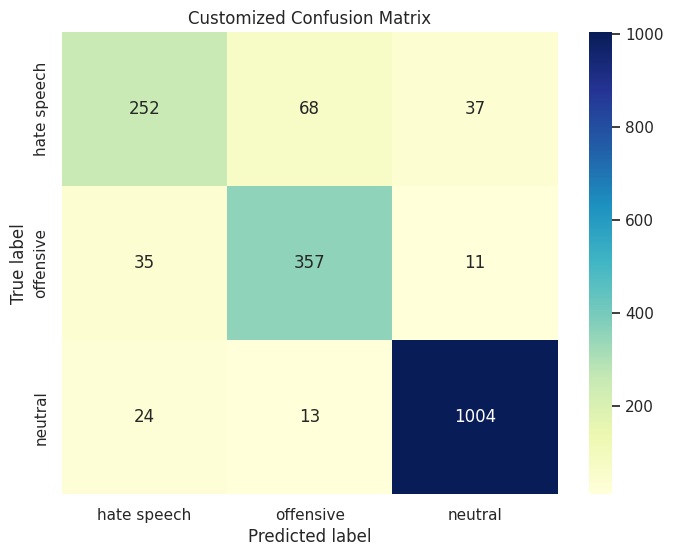

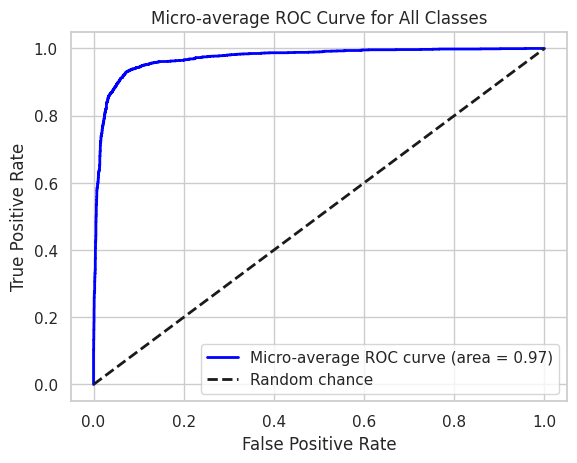

In [26]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from datasets import Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load the pre-trained BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Adjust num_labels for your classes
model.to(device)

# Preprocess the data
def preprocess(data, labels):
    # Tokenize the data
    encodings = tokenizer(data, truncation=True, padding=True, max_length=128)
    return Dataset.from_dict({'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'], 'labels': labels})

# Convert train and test data into BERT input format
train_data = preprocess(X_trainF, y_trainF)
test_data = preprocess(X_testF, y_testF)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Set up data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Set up training arguments with checkpoint saving
training_args = TrainingArguments(
    output_dir='./results',  # Directory where checkpoints are saved
    evaluation_strategy="epoch",
    save_strategy="epoch",   # Save checkpoint at end of each epoch
    save_steps=500,          # Optionally, save every 500 steps for finer granularity
    save_total_limit=3,      # Keep only the last 3 checkpoints
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',    # Directory for training logs
    report_to="none"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model and save checkpoints
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print("Evaluation Results:", eval_result)

# Get predictions for the test set
predictions = trainer.predict(test_data)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = np.array(y_testF)

# Plot the Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu", cbar=True,
            xticklabels=["hate speech", "offensive", "neutral"],
            yticklabels=["hate speech", "offensive", "neutral"])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Customized Confusion Matrix")
plt.show()

# Plot the ROC Curve
y_test_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_test_bin.shape[1]

# Convert logits to probabilities using softmax
y_score = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2,
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-average ROC Curve for All Classes")
plt.legend(loc="lower right")
plt.show()
